# Evaluate Modified Algorithms - part 2

## SMOTEBoost

In [1]:
from SMOTEBoost import SMOTEBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
from matplotlib import pyplot as plt
import numpy as np
seed=0
def simulate_dataset(n_samples=1000, weights=(0.01, 0.05, 0.05, 0.89), n_classes=4,
                   class_sep=0.9, n_clusters=1):
    X, y = make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=seed)
    return X, y

# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT
# plot the decision function of a classifier given some data
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [2]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
X, y = simulate_dataset()
# split dataset into training and test sets
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed)
sss.get_n_splits(X, y)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

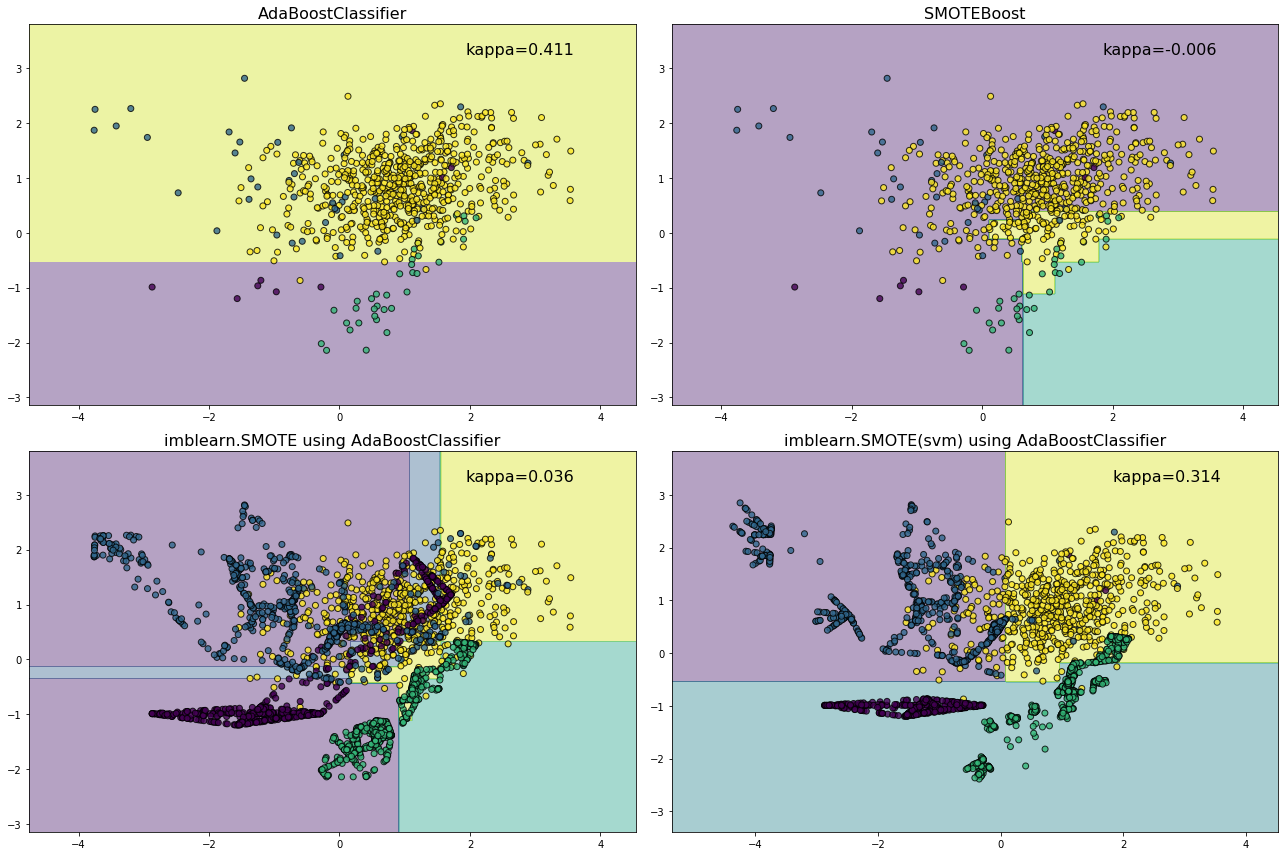

In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

adaboost = AdaBoostClassifier(random_state=seed)
smoteboost = SMOTEBoost(random_state=seed)
imblearn = make_pipeline(SMOTE(random_state=seed),adaboost)
classifiers = [adaboost, smoteboost, imblearn]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(18, 12))
ax_arr = (ax1, ax2, ax3)
for ax, clf in zip(ax_arr, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    kappa = cohen_kappa_score(y_test, y_pred)

    if clf.__class__.__name__ == 'Pipeline':
        X_res, y_res = SMOTE(random_state=seed).fit_sample(X_train, y_train)
        plot_decision_function(X_res, y_res, clf, ax)
        ax.set_title('imblearn.SMOTE using AdaBoostClassifier', fontsize=16)
    else:
        plot_decision_function(X_train, y_train, clf, ax)
        ax.set_title('{}'.format(
            clf.__class__.__name__), fontsize=16)
    ax.text(3.6, 3.2, 'kappa={}'.format(round(kappa,3)),
            verticalalignment='bottom', horizontalalignment='right',
            fontsize=16)
clf = make_pipeline(SMOTE(kind='svm', random_state=seed),adaboost)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
kappa = cohen_kappa_score(y_test, y_pred)
X_res, y_res = SMOTE(kind='svm', random_state=seed).fit_sample(X_train, y_train)
plot_decision_function(X_res, y_res, clf, ax4)
ax4.set_title('imblearn.SMOTE(svm) using AdaBoostClassifier', fontsize=16)
ax4.text(3.6, 3.2, 'kappa={}'.format(round(kappa,3)),
        verticalalignment='bottom', horizontalalignment='right',
        fontsize=16)
fig.tight_layout()
plt.show()

Confusion matrix, without normalization
[[  0   0   4   0]
 [  0   0   2  14]
 [  0   0   8   7]
 [  0   0   1 264]]


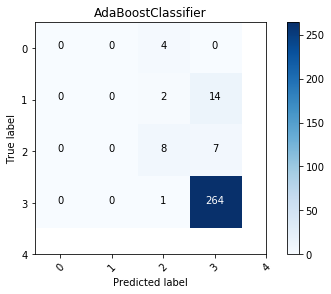

In [5]:
clf = AdaBoostClassifier(random_state=seed).fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_matrix, classes=[0,1,2,3,4], title="AdaBoostClassifier")
plt.show()

Confusion matrix, without normalization
[[  4   0   0   0]
 [ 16   0   0   0]
 [  4   0   2   9]
 [228   0   2  35]]


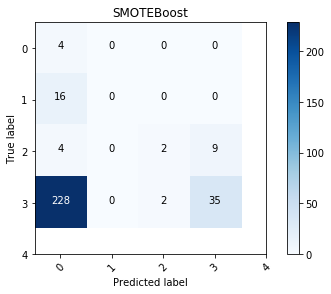

In [6]:
clf = SMOTEBoost(random_state=seed).fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_matrix, classes=[0,1,2,3,4], title="SMOTEBoost")
plt.show()

Confusion matrix, without normalization
[[  4   0   0   0]
 [ 13   2   0   1]
 [  8   0   4   3]
 [145  48   8  64]]


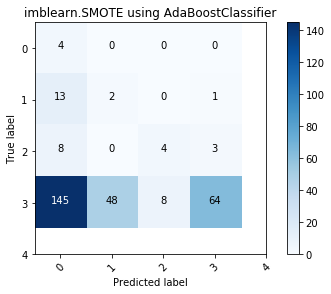

In [7]:
clf = make_pipeline(SMOTE(random_state=seed),adaboost) .fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_matrix, classes=[0,1,2,3,4], title='imblearn.SMOTE using AdaBoostClassifier')
plt.show()

Confusion matrix, without normalization
[[  0   0   4   0]
 [  0  12   2   2]
 [  0   0   9   6]
 [  0  52   7 206]]


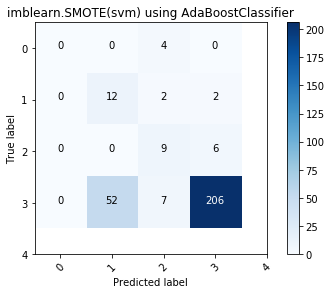

In [8]:
clf = make_pipeline(SMOTE(random_state=seed, kind='svm'),adaboost) .fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_matrix, classes=[0,1,2,3,4], title='imblearn.SMOTE(svm) using AdaBoostClassifier')
plt.show()